Drawing the corner from numpy.rec file. The benefit is that variable name is in file. Burnin is already applied.

In [2]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import seaborn as sns
from emcee.backends import HDFBackend

In [3]:
from read_files import *
from run_mcmc import HODParameter

In [9]:
with open('./configs/config_small_step_powcov.yaml', 'r') as f:
# with open('./configs/config_delta.yaml', 'r') as f:
    par_configs, other_configs = list(yaml.load_all(f, yaml.FullLoader))
    # ========== reading configs ==========
    # don't set the lgMmin too large or sig_lgM too small, otherwise N_c will be all zeros
    available_fields = ['Nwalkers', 'Nstep', 'Nburnin', 'Npro', 'auto_range', 'cross_range',
                        'backend_file', 'numpy_file', 'wp_table_path', 'signal_path', 'module_path']
    Nwalkers = 40
    Nstep = 4000
    Nburnin = 300
    Npro = 40
    auto_range = None
    cross_range = None
    backend_file = ''
    numpy_file = ''
    wp_table_path = '../wp_table'
    signal_path = '../signal'
    module_path = './HOD/calc_wp.py'

    for k in available_fields:
        if k in other_configs:
            locals()[k] = other_configs[k]

    wp_table = read_wp(wp_table_path)
    rp_auto, signal_auto, rp_cross, signal_cross = read_signal(signal_path + '/signal.npy')
    cov = read_cov(signal_path + '/cov.npy')
    logM, Nh = read_halo_mass_function('../halo_mass_function.npy')
    module = read_module(module_path)
    chi_2 = module.chi_2
    N_c = module.N_c
    # for better performance I would recommend setting these as global variable
    # ========== apply the fitting range ==========

    if auto_range or cross_range:
        if auto_range is None:
            auto_range = [0, len(rp_auto)]
        if cross_range is None:
            cross_range = [0, len(rp_cross)]
        l_a, r_a = auto_range[0], auto_range[1]
        l_c, r_c = cross_range[0], cross_range[1]

        auto_size = len(rp_auto)
        cross_size = len(rp_cross)
        rp_auto = rp_auto[l_a:r_a]
        rp_cross = rp_cross[l_c:r_c]
        signal_auto = signal_auto[l_a:r_a]
        signal_cross = signal_cross[l_c:r_c]

        cov = np.vstack((
            np.hstack((cov[l_c:r_c, l_c:r_c], cov[l_c:r_c, cross_size+l_a:cross_size+r_a])),
            np.hstack((cov[cross_size+l_a:cross_size+r_a, l_c:r_c], cov[cross_size+l_a:cross_size+r_a, cross_size+l_a:cross_size+r_a]))
        ))

    signal = np.hstack((signal_cross, signal_auto))
    cov_inv = np.linalg.inv(cov)

    # ========== handle interpolating table ==========
    wp_table_auto = interpolate_table(wp_table, rp_auto)
    wp_table_cross = interpolate_table(wp_table, rp_cross)

    parameter = HODParameter.from_config(par_configs)
    dof = len(signal) - np.isnan(signal).sum() - parameter.ndim
    print(parameter)
    print('dof = {}'.format(dof))

HODParameter(lgMmin:    14  [10~17]
             sig_lgM:   0.5 [0.001~1]
             Amp:       1   [fixed]
             lgM0:      12  [11~16]
             lgM1p:     12  [10.5~16]
             alpha:     1   [0~5])
dof = 29


In [10]:
if not numpy_file.endswith('.npy'):
    numpy_file += '.npy'
result = np.load(numpy_file)
array_2d = result.view((np.float64, len(result.dtype.names)))
backend = HDFBackend(backend_file, read_only=True)
chi2 = -backend.get_log_prob(discard=5000)*2
chain = backend.get_chain(discard=5000)
blobs = backend.get_blobs(discard=5000, thin=500, flat=True)
print('chi^2 = {}'.format(chi2.mean()))

chi^2 = 36.510389274360975


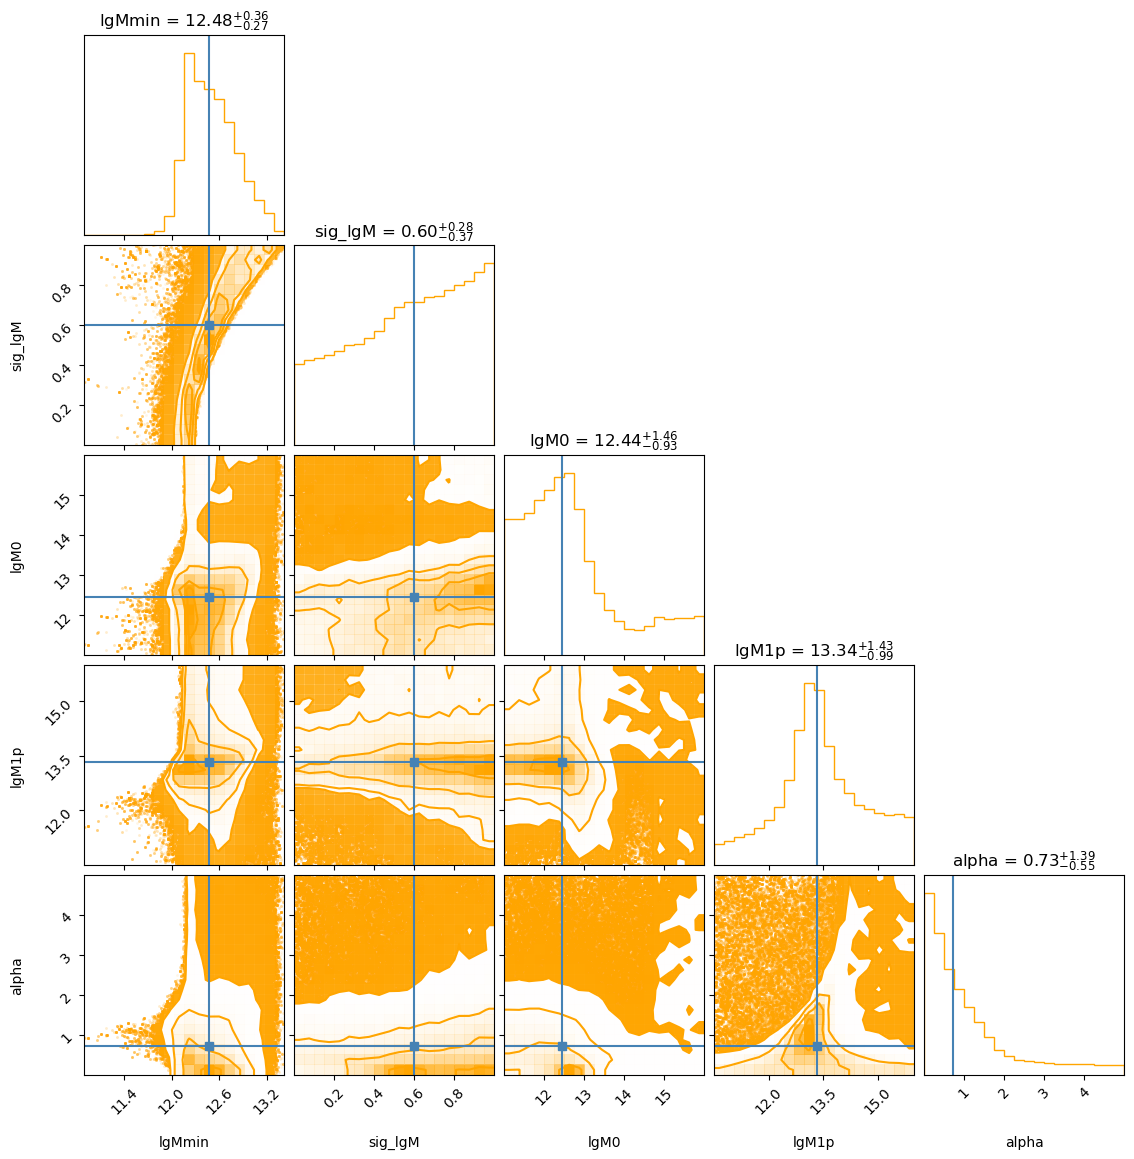

In [11]:
fig = corner.corner(array_2d, labels=result.dtype.names, show_titles=True, color='orange', truths=np.percentile(array_2d, 50, axis=0))
plt.show()

In [7]:
par = parameter.full_parameters(np.percentile(array_2d, 50, axis=0))
par

par(lgMmin=12.480362184217823, sig_lgM=0.6027966042078445, Amp=1.0, lgM0=12.469129354516989, lgM1p=13.349529159078337, alpha=0.7849045189397001)

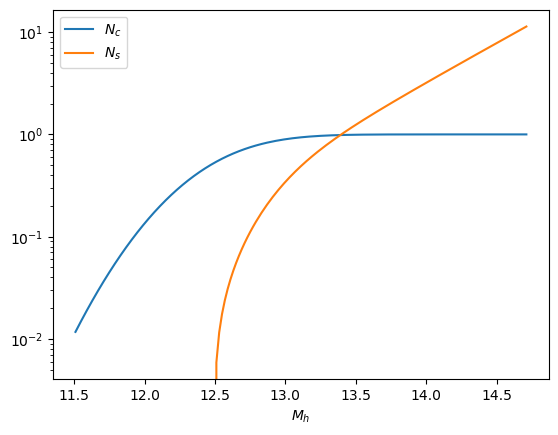

Nq = 0.0013755728402794717
fsat = 0.09861865427814571


In [26]:
nc = module.N_c(logM, par)
ns = module.N_s(logM, par)
plt.plot(logM, nc, label='$N_c$')
plt.plot(logM, ns*nc, label='$N_s$')
plt.semilogy()
plt.xlabel('$M_h$')
plt.legend()
plt.show()

Nc = (nc*Nh).sum()
Ns = (nc*ns*Nh).sum()

print('Nq = {}'.format(Nc+Ns))
print('fsat = {}'.format(Ns/(Nc+Ns)))

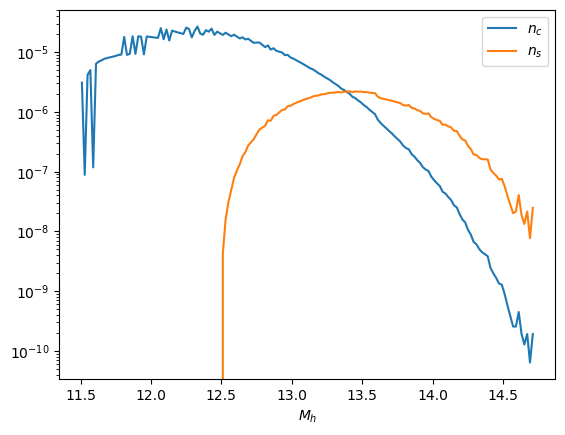

Nq = 0.0013755728402794717
fsat = 0.09861865427814571


In [28]:
nc = module.N_c(logM, par)
ns = module.N_s(logM, par)
plt.plot(logM, nc*Nh, label='$n_c$')
plt.plot(logM, ns*ns*Nh, label='$n_s$')
plt.semilogy()
plt.xlabel('$M_h$')
plt.legend()
plt.show()

Nc = (nc*Nh).sum()
Ns = (nc*ns*Nh).sum()

print('Nq = {}'.format(Nc+Ns))
print('fsat = {}'.format(Ns/(Nc+Ns)))

0.1031778563866154-0.10317608636712661+0.18244640348915414


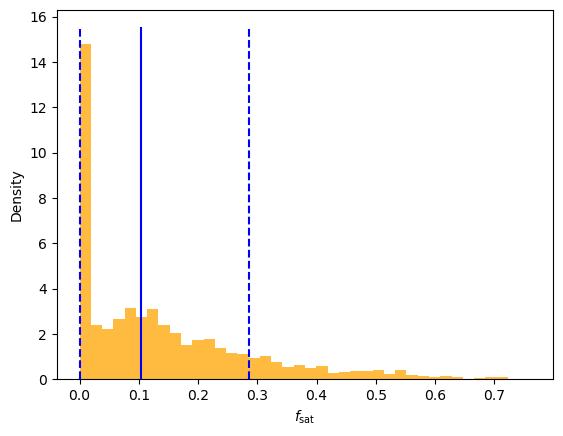

In [12]:
dat = blobs['fsat']#[chi2 < np.percentile(chi2, 50)]
d, m, u = np.percentile(dat, [50-34.1, 50, 50+34.1])
print('{}-{}+{}'.format(m, m-d, u-m))
axe = sns.histplot(dat, bins=40, stat='density', linewidth=0, color='orange', fill=True)
axe.set_xlabel(r'$f_{\text{sat}}$')
bottom, top = axe.get_ylim()
axe.vlines([d, u], bottom, top, colors='blue', linestyles='dashed')
axe.vlines([m], bottom, top, colors='blue', linestyles='solid')

In [13]:
predict = module.w_p(logM, Nh, par, wp_table_auto, wp_table_cross)
pre_cross = predict[:len(rp_cross)]
pre_auto = predict[len(rp_cross):]
std = np.sqrt([cov[i, i] for i in range(len(signal))])
err_cross = std[:len(rp_cross)]
err_auto = std[len(rp_cross):]

[]

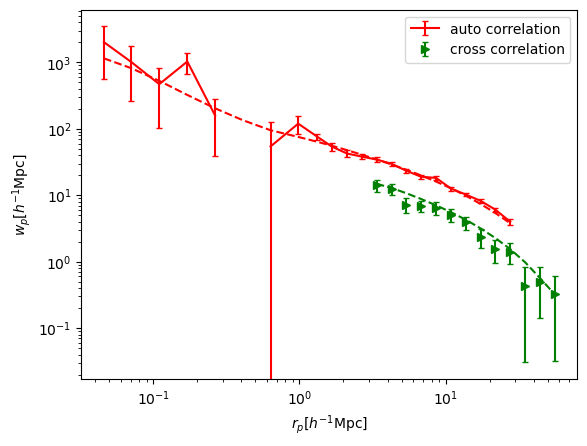

In [14]:
plt.errorbar(rp_auto, signal_auto, err_auto, fmt='r', capsize=2, label='auto correlation')
plt.errorbar(rp_cross, signal_cross, err_cross, fmt='g>', capsize=2, label='cross correlation')
plt.plot(rp_auto, pre_auto, 'r--')
plt.plot(rp_cross, pre_cross, 'g--')
plt.xlabel(r'$r_p[h^{-1}\mathrm{Mpc}]$')
plt.ylabel(r'$w_p[h^{-1}\mathrm{Mpc}]$')
plt.legend()
plt.loglog()

In [14]:
print(((signal_auto - pre_auto) / err_auto)**2)
print(((signal_cross - pre_cross) / err_cross)**2)

print(np.nansum(((signal_auto - pre_auto) / err_auto)**2) / (len(signal_auto) - 1))
print(np.sum(((signal_cross - pre_cross) / err_cross)**2) / len(signal_cross))

[3.52225266e-01 6.64807808e-02 2.46569645e-02 3.86594171e+00
 1.42196592e-01            nan 3.17296852e-01 1.49922782e+00
 3.75964655e+00 8.64016270e-02 1.50085852e+00 7.54636614e-01
 8.76523362e-04 1.02055339e-01 2.55032226e-01 4.27326889e-01
 4.68206260e+00 3.19076236e-02 3.89267958e-01 2.38153721e+00
 2.53741833e+00 2.69804181e-01]
[8.44944126e-02 6.84338631e-02 3.35856265e+00 1.74352309e+00
 1.98225355e-01 2.48572792e-01 2.11359286e-01 1.21146891e+00
 1.51745745e+00 6.89378820e-02 1.82270445e+00 5.27375748e-02
 1.40442348e-04]
1.1165170549824492
0.8143552429478499


In [11]:
np.nansum((((signal_auto - pre_auto) / err_auto)**2)[:8]) / (8 - 1)

0.8910892097555527

In [12]:
np.sum((((signal_auto - pre_auto) / err_auto)**2)[8:]) / (14)

1.0158178219556477

In [13]:
np.sum(((signal_cross - pre_cross) / err_cross)**2) / len(signal_cross)

0.8063278101957412